### Decoding strategy 1: Temperature scaling

In [15]:
### Previously, inside the generate_text_simple_function, we always sampled the token with the highest probability as the next
### token using torch.argmax, also known as greedy decoding.
### To generate text with more variety, we can replace the argmax with a function that samples from a probability distribution

In [3]:
import torch

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "towards": 7,
    "you": 8
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
# Assume the LLM is given the start context "every effort moves you" and generates the following next output logits
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [5]:
probas = torch.softmax(next_token_logits, dim=0)
print(probas)
next_token_id = torch.argmax(probas).item()
print(next_token_id)
print(inverse_vocab[next_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


In [ ]:
### To implement a probabilistic sampling process, we can now replace the argmax with thr multinomial function in pytorch

In [7]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [8]:
### The multinomial function samples the next token proportional to its probability score, in other words, "forward" is still the 
### most likely token and will be selected by multinomial most of the time but not all the time.
### To illustrate this, lets implement a function that repeats this sampling 1000 times.

In [9]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x towards


In [10]:
### As we can see, the word "forward" is sampled most of the time, but other tokens like "closer", "inches", "towards" will also
### be sampled some of the time.
### This means that if we replaced the argmax function with the multinomial function inside the generate_and_print_sample 
### function, the LLM would sometimes generate texts such as "ever effort moves you toward", "every effort moves you inches",
### "every effort moves you closer" instead of "every effort moves you forward".

In [11]:
### We can further control the distribution and selection process via a concept called temperature scaling, where temperature
### scaling is just a fancy description for dividing the logits by a number greater than 0.
### Temperature greater than 1, results in more uniformly distributed token probabilities, and temperature smaller than 1, 
### will result in more confident distributions.

In [12]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values 
temperatures = [1, 0.1, 5]   # Original, higher confidence, lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

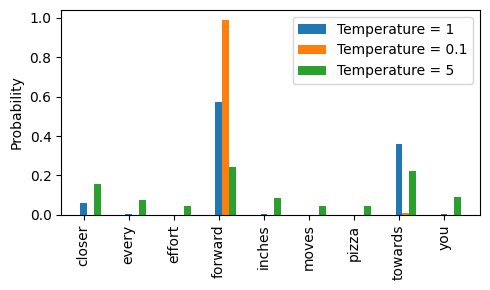

In [13]:
import matplotlib.pyplot as plt

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
    
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [14]:
### Applying very small temperatures such as 0.1 will result in sharper distributions such that the behavior of the multinomial
### function the selects the most likely token almost 100% of the time, approaching the behavior of the argmax function.
### Vice versa, a temperature of 5 results in a more uniform distribution where other tokens are selected more often.
### This can add more variety to the generated texts but also more often results in nonsensical text.